목차

<br>

Step 1. 데이터셋 준비하기  
    
- 1-1)

Step 2. ResNet 기본 블럭 구성하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1. 데이터셋 준비하기 

논문 **4.2 CIFAR-10 and Analysis**를 참고하여 CIFAR-10 데이터셋으로 코드 구현을 시도

<br>

**실험 목표**

- CIFAR-10에 대해 Plain Network와 ResNet을 구현
- 이 둘을 비교하여 ResNet과 residual connection의 유효성을 확인

**1) CIFAR-10**

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-1-p-cifar-10.png)

<br>

- [CIFAR-10 from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10)

<br>

- CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있다.(32x32 pixel)
- MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 <u>**물체의 종류를 분류**</u>해 본다.

<br>

먼저 데이터셋을 준비한다. 만약 텐서플로우에서 제공하는 `tensorflow-datasets` 패키지가 설치되어 있지 않다면 아래 명령어로 설치를 먼저 진행한다.

```
$ pip install tensorflow-datasets
```

## 1-1) 데이터셋 및 라이브러리 설치

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

> ❗ 코랩에서 GPU 연결을 하지 않고 위의 셀을 실행 시켰더니, `[]`만 출력되었음❗

CIFAR-10은 대용량 데이터셋은 아니지만 그래도 로드되는 데 꽤 긴 시간이 걸린다.

<br>

데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있다.  
`DatasetBuilder`의 info를 통해 정보를 확인해 볼 것!

<br>

>❗️ `tfds.load()`는 기본적으로 `~/tensorflow_datasets` 경로에 데이터셋을 다운로드한다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이다. 혹시 데이터셋 경로를 바꾸고 싶다면, `data_dir` 인자를 사용하면 된다.

> `data_dir` 인자 사용하는 법 알아두기!!!!!
[tensorflow 공식 문서](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()  # 이 주석을 풀면 데이터셋 다운로드 과정의 프로그레스바가 나타나지 않는다.

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
        
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 feature 정보를 확인 해 보자!
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인 해 보자!
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


<u>Tensorflow의 데이터셋은 Numpy가 아니므로</u> `ds_train.shape` 같은 게 존재하지 않는다.  
위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 등 가장 중요한 정보들을 확인할 수 있다.

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [ ]:
# 클래스 갯수 확인
ds_info.features["label"].num_classes

2

In [ ]:
# 클래스 레이블 이름 확인
ds_info.features["label"].names

['cat', 'dog']

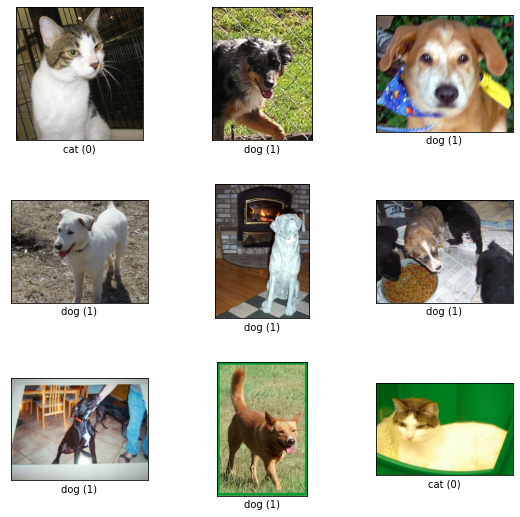

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

> ⭐`num_classes=1`, `Activation='sigmoid'`를 써야하는 이유!⭐<br><Br>
- ***dog*** : label 1
- ***cat*** : label 0


## 1-2) Data Normalization

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: 'uint8' -> 'float32'."""
    image = tf.image.resize(image, [224, 224])   # cats_vs_dogs 이미지는 사이즈가 일정하지 않은 듯 하다!
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):

    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1   
    )

    ds = ds.batch(batch_size)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

# Step 2. ResNet 기본 블럭 구성하기

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

## Going Deeper 02 프로젝트 코드 필사하기

### 1) `3x3` conv block 생성

In [ ]:
def conv_block(input_layer,
               channel,
               kernel_size,
               regularizer,
               strides=1,
               activation='relu'):
    
    x= keras.layers.Conv2D(filters=channel,
                           kernel_size=kernel_size,
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(regularizer),
                           padding='same',    # 논문에 따르면, zero padding을 넣어야한다고 함.
                           strides=strides)(input_layer)

    x = keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)  # fundamental 22에서 batch norm 레이어에 momentum(decay)와 epsilon를 넣어주었음
    
    if activation :
        x = keras.layers.Activation(activation)(x)

    return x

> 🔑**Batch Norm Layer**에서 **epsilon**이란❓<br><br>
- `momentum`: Momentum for the moving average.
- `epsilon` : Small float added to variance to avoid dividing by zero.  
<br>
- [keras 공식 문서 참고](https://keras.io/api/layers/normalization_layers/batch_normalization/)

### 2) resblock 생성

- `regularizer` : resnet 56 에서는 `1e-4`, resnet 56 이하에서는 `1e-3`을 사용한다.  

<br>

👉 Fundamental 22 에서는 `l2_weight_decay`라는 이름으로 설정되어 있다.

In [ ]:
def resblock(input_layer,
             num_conv=3,
             channel=64,
             block_num=0,
             is_50=True):
    
    x = input_layer

    # ResNet-50 이상의 모델
    if is_50:
        regularizer=1e-4
        for i in range(num_conv):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), regularizer, strides=2, activation=None)   
                # shortcut은 입력 그대로 더해져야하기 때문에, activation을 실행하지 않음
                # filter = (1,1), strides=2의 결과는 56x56 👉 28.5이 됨 (논문에서는 28x28, 소숫점 아래는 버림)
                # feature map size를 절반으로 줄이기 위해서 사용
                x = conv_block(x, channel, (1,1), regularizer, strides=2)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1), regularizer)

            x = conv_block(x, channel, (3,3), regularizer)
            x = conv_block(x, channel*4, (1,1), regularizer, activation=None)   # 마지막 1x1 conv는 채널 수가 4배이다 (논문참조)

            x = keras.layers.Add()([x, shortcut])   # Relu 이전에 더해준다.
            x = keras.layers.Activation('relu')(x)  

    # ResNet-34 이하의 모델
    else:
        regularizer=1e-3
        for i in range(num_conv):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), regularizer, strides=2, activation=None)
                x = conv_block(x, channel, (3,3), regularizer, strides=2)    # feature map 사이즈 조절이 필요함
            else:
                shortcut = x   # 맨 처음으로 들어오는 입력을 그대로 통과 시킨다. 첫 번째 conv 블록 바로 이전도 3x3 max pool이었기 떄문에 사이즈 조절이 필요하지 않음
                x = conv_block(x, channel, (3,3), regularizer)
                
            x = conv_block(x, channel, (3,3), regularizer, activation=None)

            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    return x

### 3) Build ResNet Architecture

In [ ]:
def build_resnet(input_shape=(224,224,3),
                 num_conv_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=1,   
                 is_50=True,
                 activation='sigmoid',
                 name='ResNet_50'):
    
    assert len(num_conv_list) == len(channel_list)
    # assert : 뒤에 따라오는 조건이 True가 아니면 AssertError를 발생 시킨다.

    input_layer = keras.layers.Input(shape=input_shape)  #  input layer를 만들어 둔다.

    name = ''
    # first layer
    if is_50:
        regularizer=1e-4
        name = 'Resnet-50' 
    else:
        regularizer=1e-3
        name = 'Resnet-34' 
    
    x = conv_block(input_layer, 64, (7, 7), regularizer, strides=2)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

    for block_num, (num_conv, channel) in enumerate(zip(num_conv_list, channel_list)):
        x = resblock(x, num_conv=num_conv, channel=channel, block_num=block_num, is_50=is_50)

    x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.Flatten(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal')(x)

    model = keras.Model(inputs=input_layer, outputs=x, name=name)

    return model   # return을 사용하면 for문을 포함한 함수가 종료된다.

> 🙋‍♂️ **Going Deeper CV-2와 달라진 코드**<br><Br>
- ***GAP***, ***FC-layer***, ***model*** 코드를 <u>for문 밖으로 꺼냄</u>
- ***name*** 을 따로 if문을 만드는 대신, ***regularizer***를 구분하기 위해 생성한 if문안으로 넣어줌

### 4) ResNet-34 모델 구조 확인

In [ ]:
resnet_34 = build_resnet(is_50=False)
resnet_34.summary()

Model: "Resnet-34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

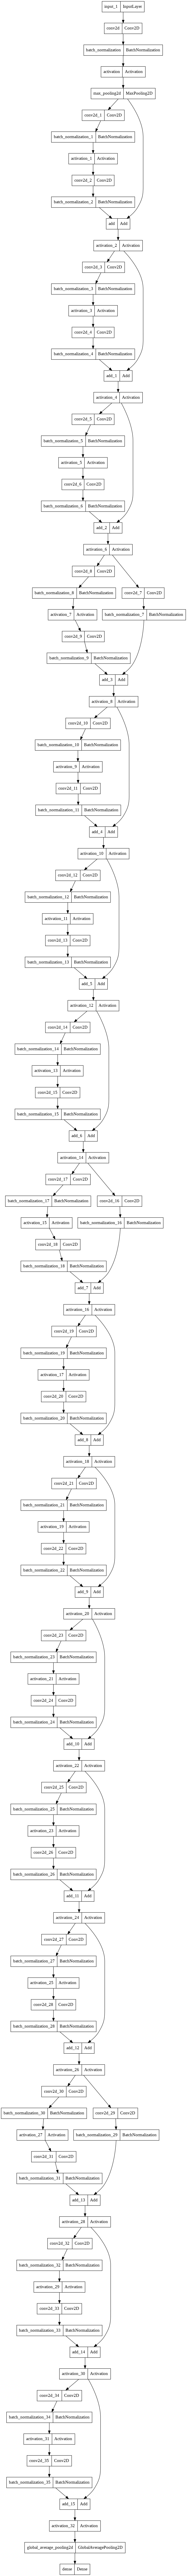

In [ ]:
plot_model(resnet_34)

### 5) ResNet-50 모델 구조 확인

In [ ]:
resnet_50 = build_resnet()
resnet_50.summary()

Model: "Resnet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

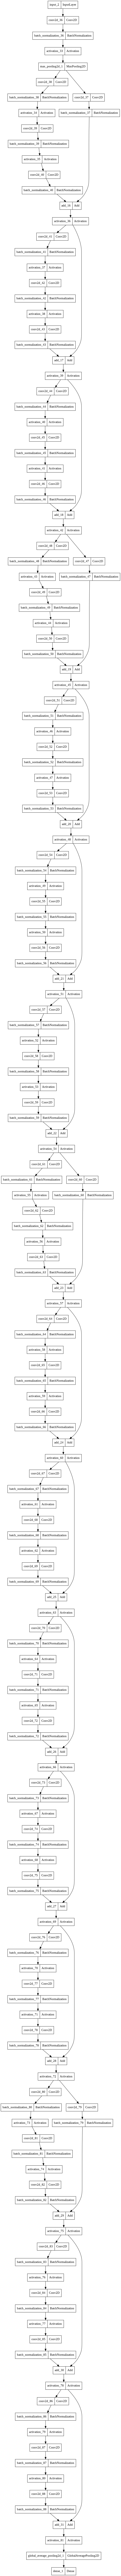

In [ ]:
plot_model(resnet_50)

### 6) plain network

- *3)*에서 생성했던 resblock에서 shortcut만 제외한 **plain block**을 만든다.

In [ ]:
# resnet block에서 shortcut을 제외한 plain block
def plain_block(input_layer, 
                      num_conv=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        regularizer=1e-4
        for i in range(num_conv):
            if block_num > 0 and i == 0:   # shortcut이 없기 때문에 첫 번째 블록의 feature map 사이즈 조절이 필요하지 않음
                x = conv_block(x, channel, (1,1), regularizer, strides=2)
            else:
                x = conv_block(x, channel, (1,1), regularizer)

            x = conv_block(x, channel, (3,3), regularizer)
            x = conv_block(x, channel*4, (1,1), regularizer)
    
    # plain-34
    else:
        regularizer=1e-3
        for i in range(num_conv):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), regularizer, strides=2)
            else:
                x = conv_block(x, channel, (3,3), regularizer)

            x = conv_block(x, channel, (3,3), regularizer)

    return x

### 7) Build Plain Net Architecture

In [ ]:
def build_plainnet(input_shape=(224,224,3), 
                   num_conv_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=1,
                   is_50=True, 
                   activation='sigmoid',
                   name='Plain_50'):
    
    assert len(num_conv_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)

    name = ''
    
    # first layer
    if is_50:
        regularizer=1e-4
        name = 'Plain_50'
    else:
        regularizer=1e-3
        name = 'Plain_34'
        
    x = conv_block(input_layer, 64, (7,7), regularizer, strides=2)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_conv, channel) in enumerate(zip(num_conv_list, channel_list)):
        x = plain_block(x, 
                              num_conv=num_conv, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.Flatten(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 8) Plain-34 모델 구조 확인

In [ ]:
plain_34 = build_plainnet(is_50=False)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        369

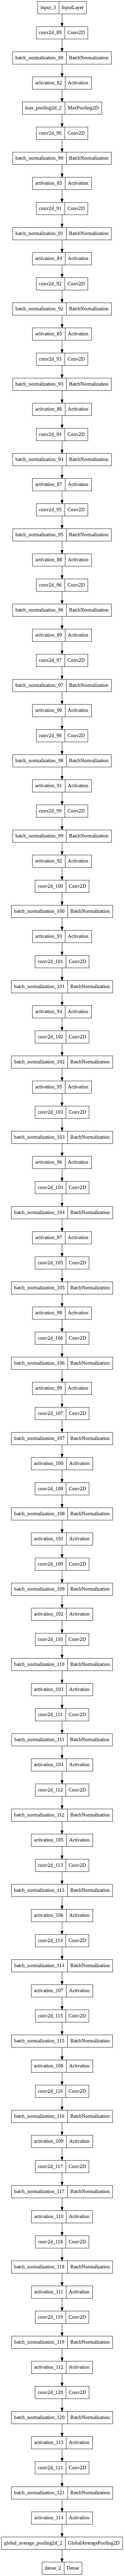

In [ ]:
plot_model(plain_34)

### 9) Plain_50 모델 구조 확인

In [ ]:
plain_50 = build_plainnet()
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        416

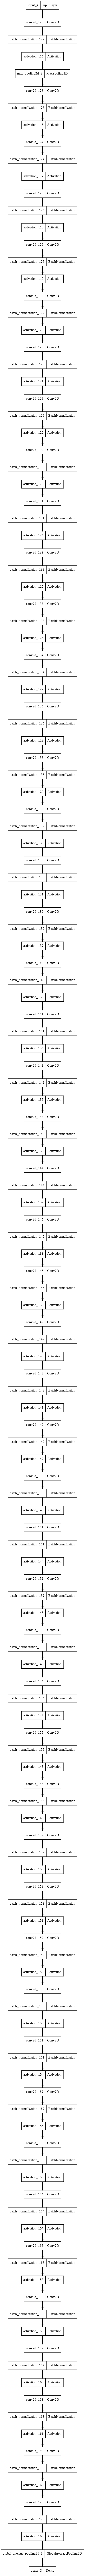

In [ ]:
plot_model(plain_50)

In [ ]:
del resnet_34
del resnet_50
del plain_34
del plain_50

❌***뒷 부분에서 새로 모델을 생성해야 하므로 삭제해 준다***❌

# Step 3. 학습 진행

## Data Normalization 실행

- **ResNet 논문**에서처럼 배치사이즈를 256으로 했더니, RAM 초과로 세션이 다운됨.
- 데이터 셋도 작아서 배치사이즈를 `16`으로 설정하고 진행함
- **optimizer** : SGD, learning rate 0.1, 모멘텀 0.9, decay 1e-5 👉 **ResNet 논문**내용 참고

<br>

`apply_normalize_on_dataset()`은 **1-2) Data Normalization**에서 만들어 둔 함수이다.

In [ ]:
BATCH_SIZE = 16
EPOCH = 50

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)  

> 🙋‍♂️ **Going Deeper CV-2와 달라진 코드**<br><Br>
- `is_test=Ture`를 ***ds_test***의 파라미터로 추가 해 준다. (노드에는 적혀있지 않았음)

## ResNet-34

> 🙋‍♂️ **Going Deeper CV-2와 달라진 코드**<br><Br>
- ***loss function*** 👉 `sparse_categorical_crossentropy`로 변경  
✅ 그냥 `categorical_crossentropy`를 사용했더니 학습 진행이 되지 않았음! ✅ 

In [ ]:
resnet_34 = build_resnet(is_50=False)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-5),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/50
1163/1163 [==============================] - 93s 72ms/step - loss: 17.6460 - accuracy: 0.6015 - val_loss: 17.5911 - val_accuracy: 0.6239
Epoch 2/50
1163/1163 [==============================] - 79s 68ms/step - loss: 17.5303 - accuracy: 0.6452 - val_loss: 17.4728 - val_accuracy: 0.6651
Epoch 3/50
1163/1163 [==============================] - 78s 67ms/step - loss: 17.4278 - accuracy: 0.6754 - val_loss: 17.3681 - val_accuracy: 0.7022
Epoch 4/50
1163/1163 [==============================] - 78s 67ms/step - loss: 17.3107 - accuracy: 0.7128 - val_loss: 17.3921 - val_accuracy: 0.6459
Epoch 5/50
1163/1163 [==============================] - 78s 67ms/step - loss: 17.2073 - accuracy: 0.7374 - val_loss: 17.1649 - val_accuracy: 0.7453
Epoch 6/50
1163/1163 [==============================] - 79s 68ms/step - loss: 17.0958 - accuracy: 0.7621 - val_loss: 17.0636 - val_accuracy: 0.7644
Epoch 7/50
1163/1163 [==============================] - 79s 68ms/step - loss: 16.9773 - accuracy: 0.7913 - val_l

In [ ]:
import pandas as pd

df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_34.csv', index=False)

## ResNet-50

In [ ]:
resnet_50 = build_resnet()

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-5),
    metrics=['accuracy']
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/50
1163/1163 [==============================] - 79s 60ms/step - loss: 6.0213 - accuracy: 0.5291 - val_loss: 6.0377 - val_accuracy: 0.5250
Epoch 2/50
1163/1163 [==============================] - 69s 59ms/step - loss: 6.0136 - accuracy: 0.5313 - val_loss: 6.0016 - val_accuracy: 0.5616
Epoch 3/50
1163/1163 [==============================] - 69s 59ms/step - loss: 6.0034 - accuracy: 0.5514 - val_loss: 6.0304 - val_accuracy: 0.5578
Epoch 4/50
1163/1163 [==============================] - 69s 59ms/step - loss: 5.9935 - accuracy: 0.5676 - val_loss: 5.9972 - val_accuracy: 0.5685
Epoch 5/50
1163/1163 [==============================] - 69s 60ms/step - loss: 5.9827 - accuracy: 0.5816 - val_loss: 5.9906 - val_accuracy: 0.5862
Epoch 6/50
1163/1163 [==============================] - 69s 60ms/step - loss: 5.9800 - accuracy: 0.5855 - val_loss: 5.9835 - val_accuracy: 0.5901
Epoch 7/50
1163/1163 [==============================] - 71s 61ms/step - loss: 5.9685 - accuracy: 0.5997 - val_loss: 5.9614 -

In [ ]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_50.csv', index=False)

## Plain-34

In [ ]:
plain_34 = build_plainnet(is_50=False)

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-5),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 87s 69ms/step - loss: 15.8909 - accuracy: 0.5154 - val_loss: 15.8721 - val_accuracy: 0.5179
Epoch 2/50
1163/1163 [==============================] - 80s 68ms/step - loss: 15.8217 - accuracy: 0.5305 - val_loss: 15.8006 - val_accuracy: 0.5125
Epoch 3/50
1163/1163 [==============================] - 75s 65ms/step - loss: 15.7510 - accuracy: 0.5482 - val_loss: 15.7217 - val_accuracy: 0.5450
Epoch 4/50
1163/1163 [==============================] - 75s 65ms/step - loss: 15.6786 - accuracy: 0.5640 - val_loss: 15.6338 - val_accuracy: 0.5916
Epoch 5/50
1163/1163 [==============================] - 75s 65ms/step - loss: 15.5945 - accuracy: 0.6009 - val_loss: 15.5554 - val_accuracy: 0.6179
Epoch 6/50
1163/1163 [==============================] - 80s 69ms/step - loss: 15.5200 - accuracy: 0.6153 - val_loss: 15.4846 - val_accuracy: 0.6330
Epoch 7/50
1163/1163 [==============================] - 76s 66ms/step - loss: 15.4503 - accuracy: 0.6242 - val_l

In [ ]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_34.csv', index=False)

## Plain-50

In [ ]:
plain_50 = build_plainnet()

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-5),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 116s 93ms/step - loss: 5.2434 - accuracy: 0.5204 - val_loss: 5.2446 - val_accuracy: 0.5261
Epoch 2/50
1163/1163 [==============================] - 107s 92ms/step - loss: 5.2430 - accuracy: 0.5132 - val_loss: 5.2493 - val_accuracy: 0.5181
Epoch 3/50
1163/1163 [==============================] - 107s 92ms/step - loss: 5.2419 - accuracy: 0.5075 - val_loss: 5.2482 - val_accuracy: 0.5009
Epoch 4/50
1163/1163 [==============================] - 107s 92ms/step - loss: 5.2373 - accuracy: 0.5196 - val_loss: 5.2445 - val_accuracy: 0.5073
Epoch 5/50
1163/1163 [==============================] - 107s 92ms/step - loss: 5.2360 - accuracy: 0.5241 - val_loss: 5.2421 - val_accuracy: 0.5041
Epoch 6/50
1163/1163 [==============================] - 108s 93ms/step - loss: 5.2311 - accuracy: 0.5426 - val_loss: 5.2325 - val_accuracy: 0.5265
Epoch 7/50
1163/1163 [==============================] - 109s 93ms/step - loss: 5.2260 - accuracy: 0.5518 - val_loss: 5

In [ ]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_50.csv', index=False)

# 모델학습 결과 비교

In [ ]:
history_resnet_34 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_34.csv')
history_plain_50 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_50.csv')

## ResNet-34와 Plain-34 비교

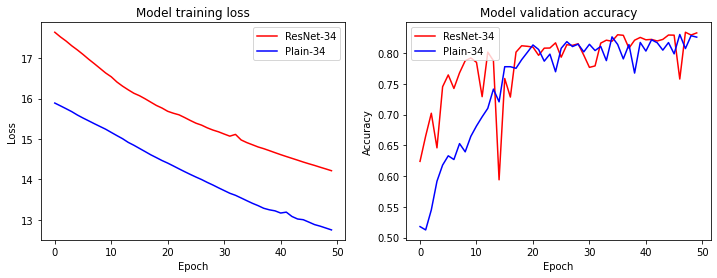

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

## ResNet-50과 Plain-50 비교

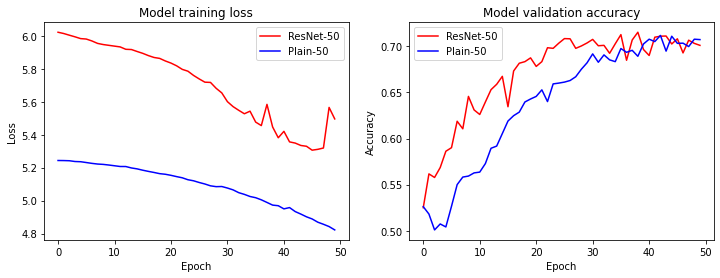

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

## 전체 비교

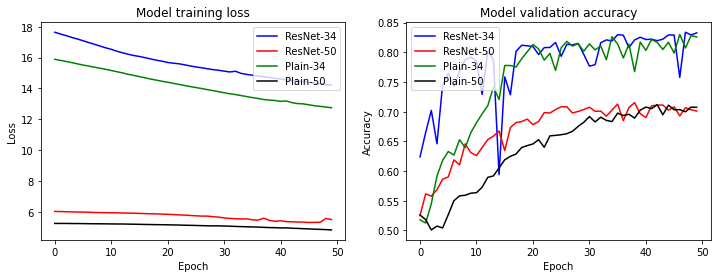

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()